# Herman Franclin Tesso Tassang

In [1]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 2.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import jax
import jax.numpy as jnp
import pandas as pd
from jax import random
# dsitributions
import numpyro
import numpyro.distributions as dist

from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi
import arviz as az
import matplotlib.pyplot as plt

import numpy as np

# Since we are using jax, we will need a random key:
rng = jax.random.PRNGKey(42)

# Bayesian workflow

## Bayesian Linear regression


# Task 18
Modify the model so that it fits better.

**Hint:** apply a transformation to input data, e.g. a polynomial.

For this model,

- plot prior predictive distribution,
- perform inference,
- plot posterior predictive dsitribution.

--2024-04-06 13:47:12--  https://raw.githubusercontent.com/deep-learning-indaba/indaba-pracs-2023/main/data/Howell1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12205 (12K) [text/plain]
Saving to: ‘Howell1.csv’

Howell1.csv         100%[===================>]  11.92K  --.-KB/s    in 0s      

2024-04-06 13:47:12 (34.5 MB/s) - ‘Howell1.csv’ saved [12205/12205]



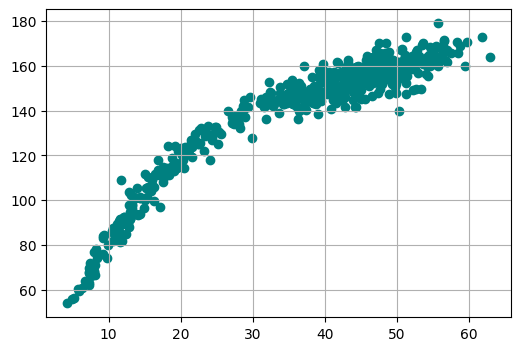

In [ ]:
## get the data

!wget -O Howell1.csv https://raw.githubusercontent.com/deep-learning-indaba/indaba-pracs-2023/main/data/Howell1.csv

df = pd.read_csv('Howell1.csv', sep=";")
df.head()

# observed data
weight = df.weight.values
height = df.height.values

# data to make predictions for
weight_pred = jnp.array([45, 40, 65, 31, 53])

# plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x='weight', y='height', data=df, color='teal')
plt.grid(0.3)

We will model it with a polynomial regression model of the form

$$y \sim N(\mu, \sigma^2),\\
\mu = b_0 + b_1 x+b_2x^{2}.$$

Here $y$ is the data we want to predict, $x$ is the predictor, $b_0$ is the bias , $b_1\ and\ b_2$ are the coefficients of first and second other respectively and $\sigma^2$ is variance.


In [ ]:
######## model
def model(weight=None, height=None):
    # priors
    b0 = numpyro.sample('b0', dist.Normal(120,50))
    b1 = numpyro.sample('b1', dist.Normal(0,1))
    b2=numpyro.sample('b2', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))

    # deterministic transformation
    mu = b0 + b1 * weight + b2*weight**2

    # likelihood: notice `obs=height`
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=height)

###### plotter
def plot_regression(x, y_mean, y_hpdi, height, ttl='Predictions with 89% CI)'):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    weight = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    ht = height[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(weight, mean, color='teal')
    ax.plot(weight, ht, 'o', color='orangered')
    ax.fill_between(weight, hpdi[0], hpdi[1], alpha=0.3, interpolate=True, color='teal')
    ax.set(xlabel='weight', ylabel='height', title=ttl);
    return ax

dict_keys(['b0', 'b1', 'b2', 'obs', 'sigma'])


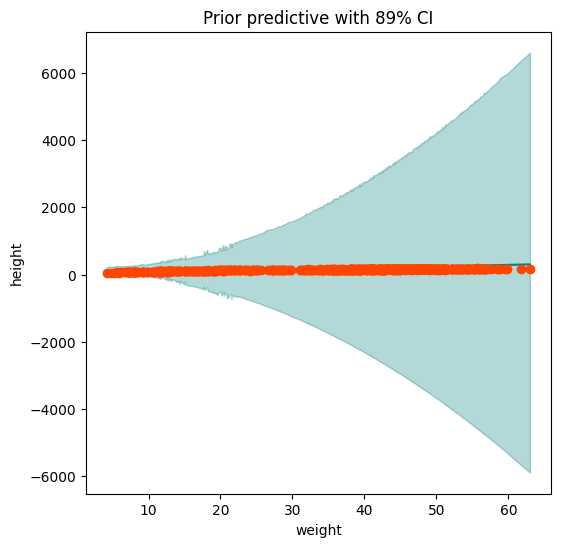

In [ ]:
#@title plot prior predictive distribution

# prior predictive
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, weight)
##
print(prior_predictions.keys())

## extract observations
pred_obs = prior_predictions['obs']
mean_prior_pred = jnp.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)

## plot
ax = plot_regression(weight, mean_prior_pred, hpdi_prior_pred, height, ttl="Prior predictive with 89% CI")

<ipython-input-51-d588bcb42287>:9: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4, progress_bar=False)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     46.03      1.19     46.01     44.10     48.01   2229.12      1.00
        b1      4.19      0.08      4.19      4.05      4.33   2199.79      1.00
        b2     -0.04      0.00     -0.04     -0.04     -0.04   2344.81      1.00
     sigma      5.77      0.18      5.77      5.47      6.05   2337.64      1.00

Number of divergences: 0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     46.03      1.19     46.01     44.10     48.01   2229.12      1.00
        b1      4.19      0.08      4.19      4.05      4.33   2199.79      1.00
        b2     -0.04      0.00     -0.04     -0.04     -0.04   2344.81      1.00
     sigma      5.77      0.18      5.77      5.47      6.05   2337.64      1.00

Number of divergences: 0


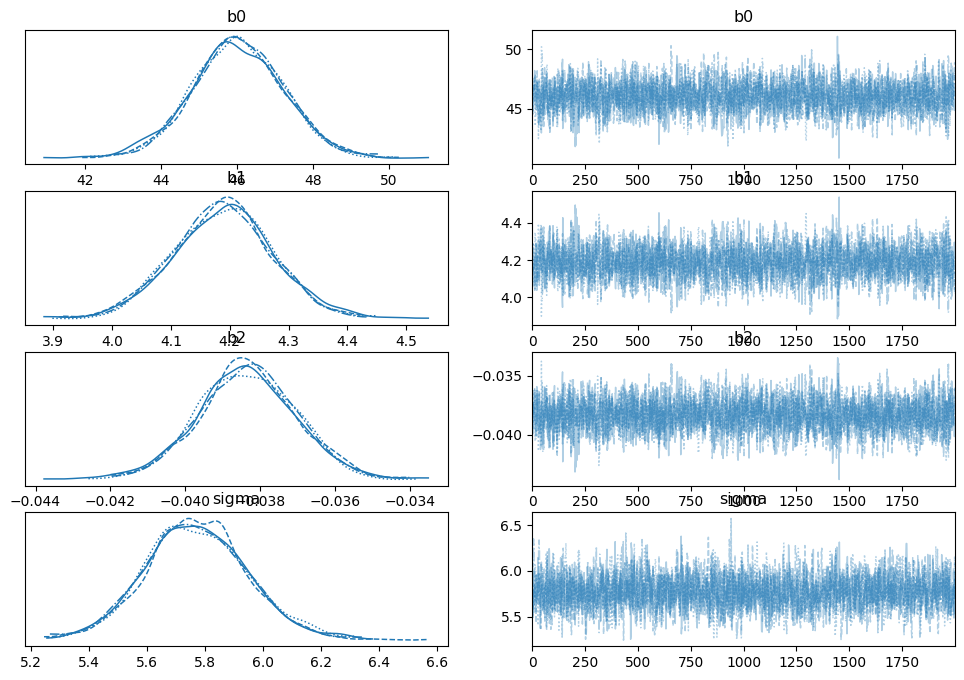

In [ ]:
#@title perform inference

# Inference
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4, progress_bar=False)
mcmc.run(rng_key_, weight=weight, height=height)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

# Check convergence
mcmc.print_summary()
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

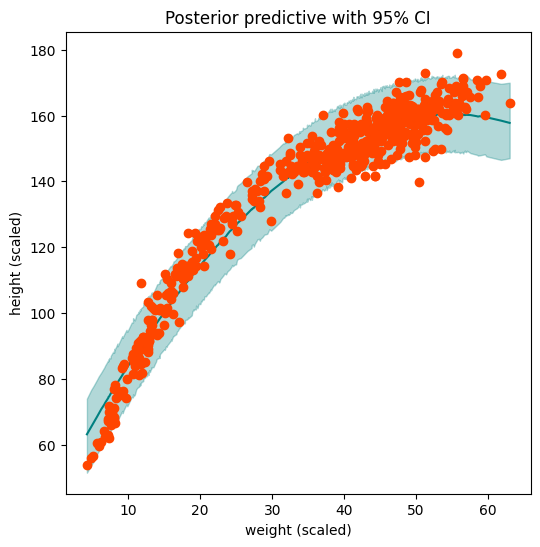

In [ ]:
#@title plot posterior predictive disitribution
# Posterior predictive
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
posterior_predictions = predictive(rng_key_, weight=weight)
post_obs = posterior_predictions['obs']

mean_post_pred = jnp.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.95)

ax = plot_regression(weight, mean_post_pred, hpdi_post_pred, height, ttl="Posterior predictive with 95% CI")
ax.set(xlabel='weight (scaled)', ylabel='height (scaled)');

#Model comparison

## Task 19
Assume that the 'true' model is $M_0$ and the two candidate models are $M_1$ and $M_2$

- $M_0: y \sim \mathcal{N}(3,2)$
- $M_1: y \sim \mathcal{N}(3.5,2.5)$
- $M_2: y \sim \text{Cauchy}(3,2)$

For these models,

- Plot the three densities
- Compute divergences $\text{KLD}(M_0 \parallel M_1)$, $\text{KLD}(M_0 \parallel M_2)$
- Which model is better: $M_1$ or $M_2$?

## Answer:
The Model $M_1$ is better than the model $M_2$ as it has the lower KL divergence value.

KLD(M_0 || M_1) =0.06065269559621811

 KLD(M_0 || M_2) =0.19840790331363678


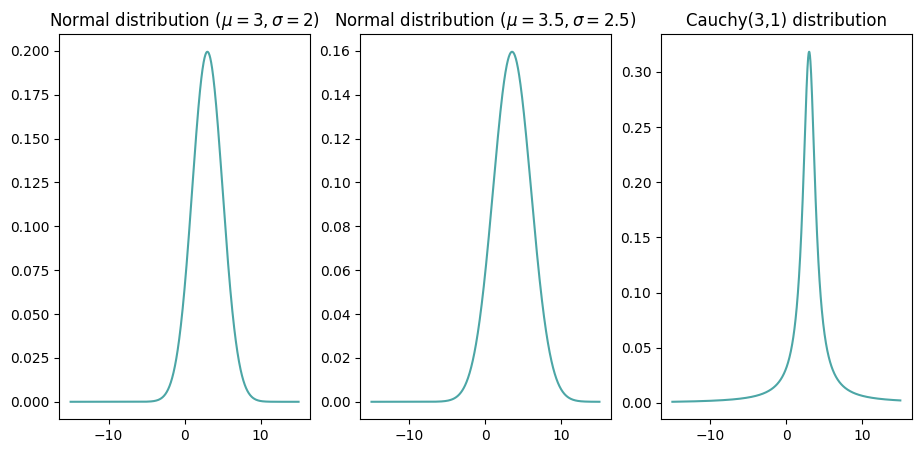

In [ ]:
## define the distributions
# Normal(3,2)

Normal1=dist.Normal(3,2)
# Normal(3.5,2.5)
Normal2=dist.Normal(3.5,2.5)
# Cauchy(3,2)
cauchy=dist.Cauchy(3,1)

x_values=jnp.linspace(-15,15,1000)
Normal1_pmf_val=jnp.exp(Normal1.log_prob(x_values))
Normal2_pmf_val=jnp.exp(Normal2.log_prob(x_values))
cauchy_pmf_val=jnp.exp(cauchy.log_prob(x_values))

## plot densities

fig,ax=plt.subplots(1,3,dpi=100, figsize=(11, 5))
ax[0].plot(x_values,Normal1_pmf_val,alpha=0.7,color='teal')
ax[1].plot(x_values,Normal2_pmf_val,alpha=0.7,color='teal')
ax[2].plot(x_values,cauchy_pmf_val,alpha=0.7,color='teal')
ax[0].set_title(f'Normal distribution ($\mu={3},\sigma={2}$)')
ax[1].set_title(f'Normal distribution ($\mu={3.5},\sigma={2.5}$)')
ax[2].set_title(f'Cauchy(3,1) distribution')

### KL_divergence function
def kl_divergence(p: dist.Distribution, q: dist.Distribution, n: int = 10_000):
  # draw n samples from the distribution P
    samples = p.sample(rng, sample_shape = (n,))

    # compute the Log probabilies
    p_log_probs = p.log_prob(samples)
    q_log_probs = q.log_prob(samples)
    # return the KL divergence value
    return (p_log_probs - q_log_probs).mean()

## $ KLD(M_0 \paralell M_1) $
print(f"KLD(M_0 || M_1) ={kl_divergence(Normal1,Normal2)}")
print('')
print(f" KLD(M_0 || M_2) ={kl_divergence(Normal1,cauchy)}")


# Model comparison


## Task 20
Download the `kidiq` dataset (Gelman & Hill, 2007), which is a data from a survey of adult American women and their respective children. Dated from 2007, it has 434 observations and 4 variables:

- `kid_score`: child's IQ

- `mom_hs`: binary/dummy (0 or 1) if the child's mother has a high school diploma

- `mom_iq`: mother's IQ

- `mom_age`: mother's age

with

 **import pandas as pd**

**!wget -O kidiq.csv https://github.com/TuringLang/TuringGLM.jl/raw/main/data/kidiq.csv**

**df = pd.read_csv('kidiq.csv')**

Construct a model predicting `kid_score`:

$$
\text{kidscore}_i \sim \mathcal{N}(\mu_i, \sigma^2),
$$

- Build separate models for the following variations of $\mu_i$:
    - $\mu_i = \beta_0 + \beta_1 \text{mom_iq}_i$
    - $\mu_i = \beta_0 + \beta_1 \text{mom_iq}_i + \beta_2 \text{mom_hs}_i$
    - $\mu_i = \beta_0 + \beta_1 \text{mom_iq}_i + \beta_2 \text{mom_hs}_i + \beta_3 \text{mom_iq}_i \times \text{mom_hs}_i$
     - $\mu_i = \beta_0 + \beta_1 \text{mom_iq}_i + \beta_2 \text{mom_hs}_i + \beta_3 \text{mom_iq}_i \times \text{mom_hs}_i + \beta_4 \text{mom_age}_i$

- Show Bayesian workflow for each of the models.

- Compare the models with each other. Which model would you chose as final and why?


##Answer:
Regarding the **WAIC** and the **LOO** metrics values, the model1 ( $ \mu_i = \beta_0 + \beta_1 \text{mom_iq}_i$ ) is consider the best as it achieves the lowest **WAIC** and **LOO**.

In [ ]:
!wget -O kidiq.csv https://github.com/TuringLang/TuringGLM.jl/raw/main/data/kidiq.csv

df = pd.read_csv('kidiq.csv')


--2024-04-06 11:53:49--  https://github.com/TuringLang/TuringGLM.jl/raw/main/data/kidiq.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TuringLang/TuringGLM.jl/main/data/kidiq.csv [following]
--2024-04-06 11:53:50--  https://raw.githubusercontent.com/TuringLang/TuringGLM.jl/main/data/kidiq.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10968 (11K) [text/plain]
Saving to: ‘kidiq.csv’

kidiq.csv           100%[===================>]  10.71K  --.-KB/s    in 0s      

2024-04-06 11:53:50 (78.7 MB/s) - ‘kidiq.csv’ saved [10968/10968]



In [ ]:
df

,kid_score,mom_hs,mom_iq,mom_age
0,65,1,121.117529,27
1,98,1,89.361882,25
2,85,1,115.443165,27
3,83,1,99.449639,25
4,115,1,92.745710,27
...,...,...,...,...
429,94,0,84.877412,21
430,76,1,92.990392,23
431,50,0,94.859708,24
432,88,1,96.856624,21


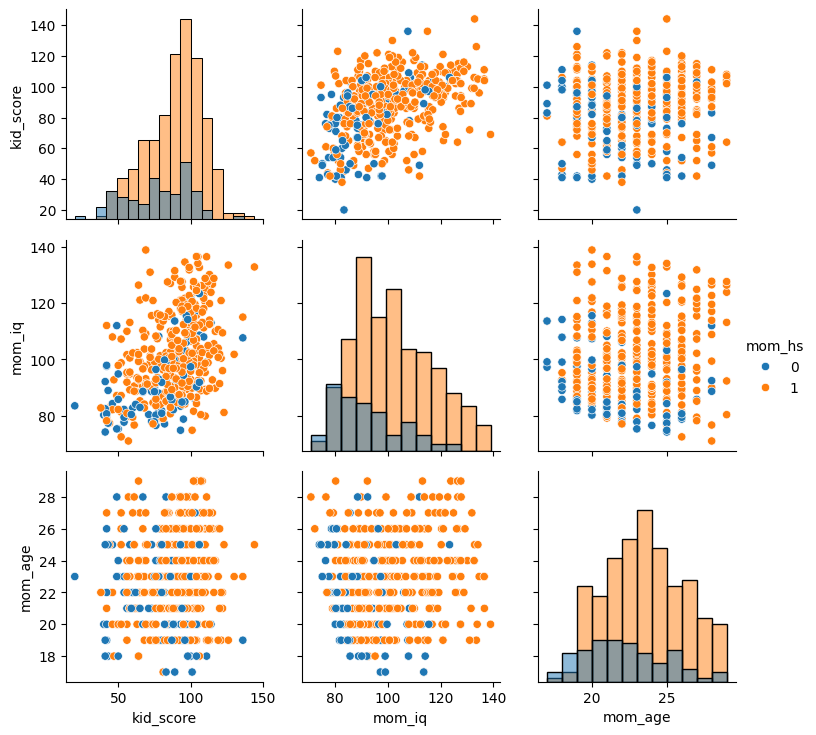

In [ ]:
#### visualise relationship between covariate and target ( goal: choose an informative prior)
import seaborn as sns
g = sns.PairGrid(df,hue="mom_hs")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [ ]:
X= df.values ## convert the Dataframe into numpy array
kid_score = df.kid_score.values


In [ ]:
rng_key = random.PRNGKey(67)

sample: 100%|██████████| 1500/1500 [00:06<00:00, 221.73it/s, 3 steps of size 1.33e-01. acc. prob=0.92] 



dict_keys(['beta', 'beta_0', 'obs', 'sigma'])

Posterior mean of beta_0: 29.099583
Posterior mean of beta_1: [0.57775736]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.58      0.06      0.58      0.49      0.68    314.16      1.01
    beta_0     29.10      5.91     29.14     19.43     38.55    309.86      1.01
     sigma     18.25      0.65     18.28     17.22     19.27    394.61      1.00

Number of divergences: 0



[Text(0.5, 0, 'mum_iq (scaled)'), Text(0, 0.5, 'kid_score (scaled)')]

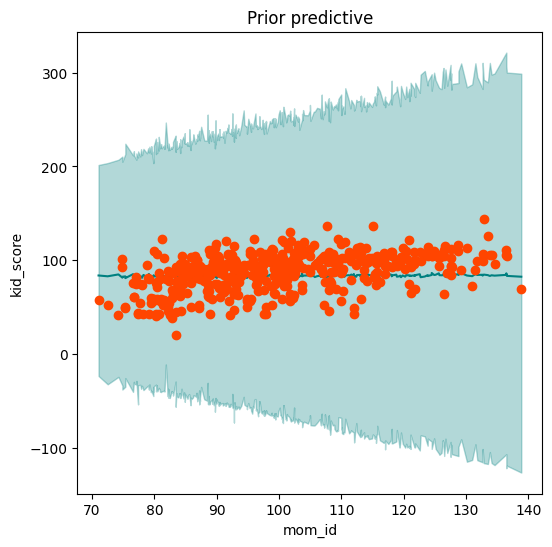

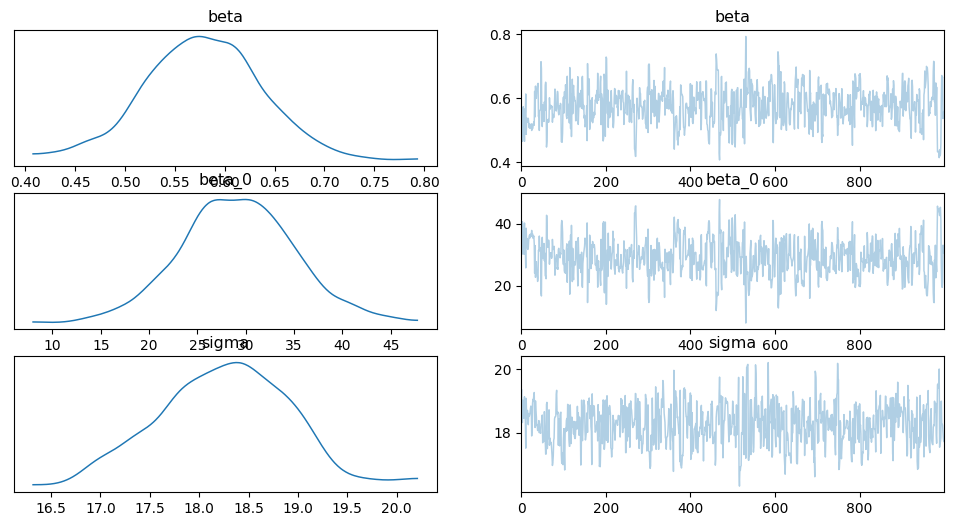

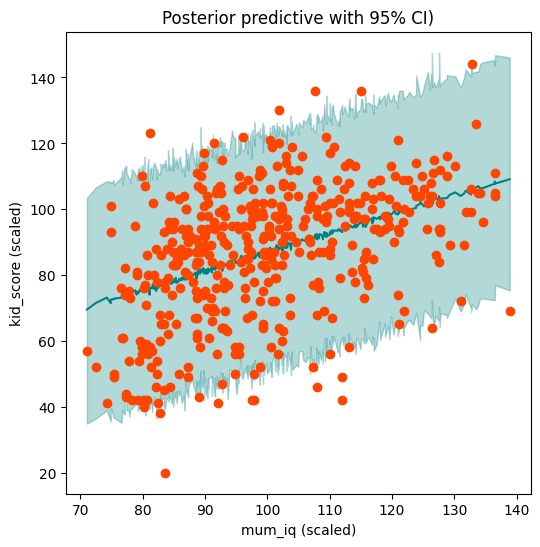

In [ ]:
#@title Model_1
#### Features/covariate
X=X[:,2].reshape(-1,1)

##################### Define the regression model ###############
def model1 (X=None, kid_score=None):

    # the number of features
    num_features =X.shape[1]

    # nummber of data points
    num_data = X.shape[0]

    # Priors
    beta_0= numpyro.sample('beta_0', dist.Normal(80, 25))
    beta= numpyro.sample('beta', dist.Normal(jnp.zeros(num_features), jnp.ones(num_features)))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))
    # precompute logits, i.e. the linear predictor
    mean= beta_0 + jnp.dot(X,beta)
    # likelihood. ( handling plate).
    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Normal(mean,sigma), obs=kid_score)

################# Inference ###############################

# Define the number of MCMC samples and the number of warmup steps
num_samples = 1000
num_warmup = 500

# Run NUTS sampler
nuts_kernel = NUTS(model1)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, progress_bar=True)
mcmc.run(rng_key, X=X, kid_score=kid_score)

########### Prior predictive check
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model1, num_samples=100)
prior_predictions = prior_predictive(rng_key_, X )

print('')
print(prior_predictions.keys())

pred_obs = prior_predictions['obs']
mean_prior_pred = jnp.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)

#### plotter

def plot_regression(x, y_mean, y_hpdi, kid_score, ttl='Predictions with 89% CI)'):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    X= x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    ht = kid_score[idx]
    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(X, mean, color='teal')
    ax.plot(X, ht, 'o', color='orangered')
    ax.fill_between(X, hpdi[0], hpdi[1], alpha=0.3, interpolate=True, color='teal')
    ax.set(xlabel='mom_id', ylabel='kid_score', title=ttl);
    return ax

ax = plot_regression(df.mom_iq.values, mean_prior_pred, hpdi_prior_pred,kid_score, ttl="Prior predictive")


################## Check Convergence ##########################

print('')
# Get posterior samples
samples = mcmc.get_samples()

# Print posterior statistics
print("Posterior mean of beta_0:", jnp.mean(samples['beta_0']))
print("Posterior mean of beta_1:", jnp.mean(samples['beta'], axis=0))

# mean is not enough
mcmc.print_summary()

print('')
# plot posterior distribution and traceplots
data_1 = az.from_numpyro(mcmc)
az.plot_trace(data_1, compact=True)

##########################  Posterior predictive  #######################

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model1, samples)
posterior_predictions = predictive(rng_key_, X=X)
post_obs = posterior_predictions['obs']

mean_post_pred = jnp.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.95)

ax = plot_regression(df.mom_iq.values, mean_post_pred, hpdi_post_pred,kid_score, ttl="Posterior predictive with 95% CI)")
ax.set(xlabel='mum_iq (scaled)', ylabel='kid_score (scaled)')


<ipython-input-12-79109a25d96d>:32: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=4, progress_bar=True)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 1523.57it/s, 31 steps of size 1.11e-01. acc. prob=0.94]




                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.57      0.06      0.57      0.48      0.67   1720.22      1.00
   beta[1]      0.99      0.89      0.99     -0.40      2.52   2613.70      1.00
    beta_0     28.66      5.70     28.67     19.51     38.08   1734.97      1.00
     sigma     18.21      0.63     18.20     17.19     19.24   2124.26      1.00

Number of divergences: 0



[Text(0.5, 0, 'mum_hs (scaled)'), Text(0, 0.5, 'kid_score (scaled)')]

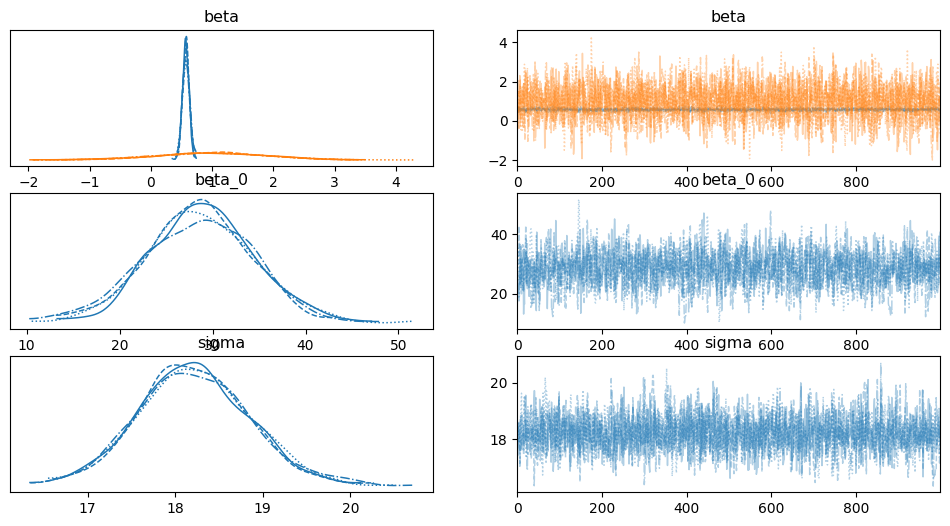

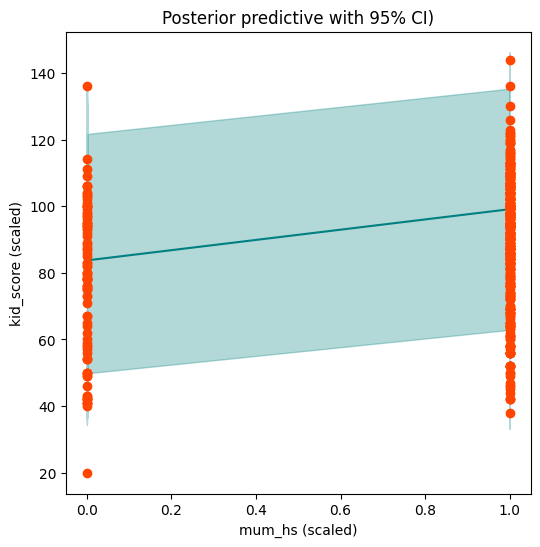

In [ ]:
#@title Model_2
#### Features/covariate
X=df[['mom_iq','mom_hs']].values

##################### Define the regression model ###############
def model2 (X=None, kid_score=None):

    # the number of features
    num_features =X.shape[1]

    # nummber of data points
    num_data = X.shape[0]

    # Priors
    beta_0= numpyro.sample('beta_0', dist.Normal(80, 25))
    beta= numpyro.sample('beta', dist.Normal(jnp.zeros(num_features), jnp.ones(num_features)))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))
    # precompute logits, i.e. the linear predictor
    mean= beta_0 + jnp.dot(X,beta)
    # likelihood. ( handling plate).
    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Normal(mean,sigma), obs=kid_score)

################# Inference ###############################

# Define the number of MCMC samples and the number of warmup steps
num_samples = 1000
num_warmup = 500

# Run NUTS sampler
nuts_kernel = NUTS(model2)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=4, progress_bar=True)
mcmc.run(rng_key, X=X, kid_score=kid_score)


################## Check Convergence ##########################

print('')
# Get posterior samples
samples = mcmc.get_samples()

# Print posterior statistics
mcmc.print_summary()

print('')
# plot posterior distribution and traceplots
data_2 = az.from_numpyro(mcmc)
az.plot_trace(data_2, compact=True)

##########################  Posterior predictive  #######################

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model2, samples)
posterior_predictions = predictive(rng_key_, X=X)
post_obs = posterior_predictions['obs']

mean_post_pred = jnp.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.95)

ax = plot_regression(df.mom_hs.values, mean_post_pred, hpdi_post_pred,kid_score, ttl="Posterior predictive with 95% CI)")
ax.set(xlabel='mum_hs (scaled)', ylabel='kid_score (scaled)')


<ipython-input-13-0f1a32c10296>:34: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=4, progress_bar=True)
sample: 100%|██████████| 1500/1500 [00:05<00:00, 268.73it/s, 31 steps of size 9.16e-02. acc. prob=0.95]




                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.50      0.07      0.50      0.39      0.61   1534.09      1.00
   beta[1]      0.13      0.96      0.15     -1.45      1.68   2313.95      1.00
   beta[2]      0.06      0.02      0.06      0.01      0.09   1761.02      1.00
    beta_0     32.71      5.91     32.64     23.81     43.10   1657.47      1.00
     sigma     18.16      0.62     18.15     17.06     19.12   2236.89      1.00

Number of divergences: 0



[Text(0.5, 0, 'mom_iq * mom_hs  (scaled)'), Text(0, 0.5, 'kid_score (scaled)')]

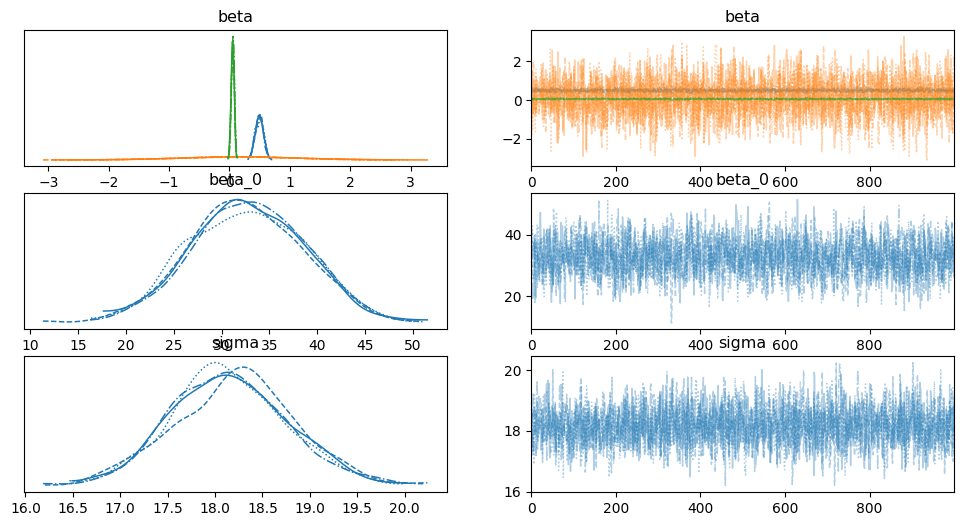

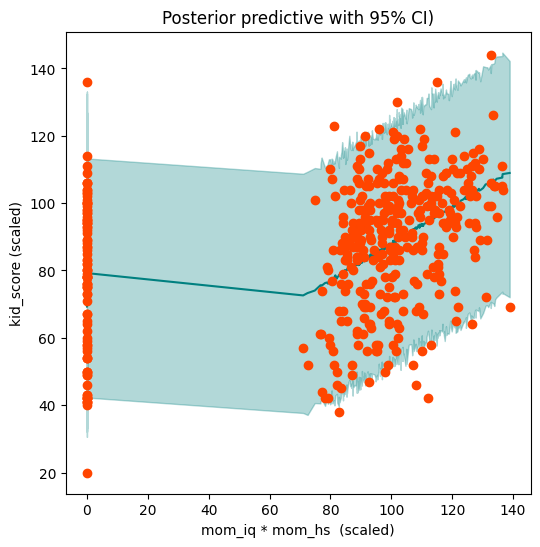

In [ ]:
#@title Model_3
## add additional column in the dataframe as result of the product "mom_iq*mom_hs" columns
df['mom_iq_product_mom_hs']=df['mom_iq']*df['mom_hs']
#### Features/covariate
X=df[['mom_iq','mom_hs','mom_iq_product_mom_hs']].values

##################### Define the regression model ###############
def model3 (X=None, kid_score=None):

    # the number of features
    num_features =X.shape[1]

    # nummber of data points
    num_data = X.shape[0]

    # Priors
    beta_0= numpyro.sample('beta_0', dist.Normal(80, 25))
    beta= numpyro.sample('beta', dist.Normal(jnp.zeros(num_features), jnp.ones(num_features)))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))
    # precompute logits, i.e. the linear predictor
    mean= beta_0 + jnp.dot(X,beta)
    # likelihood. ( handling plate).
    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Normal(mean,sigma), obs=kid_score)

################# Inference ###############################

# Define the number of MCMC samples and the number of warmup steps
num_samples = 1000
num_warmup = 500

# Run NUTS sampler
nuts_kernel = NUTS(model3)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=4, progress_bar=True)
mcmc.run(rng_key, X=X, kid_score=kid_score)


################## Check Convergence ##########################

print('')
# Get posterior samples
samples = mcmc.get_samples()

# Print posterior statistics
mcmc.print_summary()

print('')
# plot posterior distribution and traceplots
data_3= az.from_numpyro(mcmc)
az.plot_trace(data_3, compact=True)

##########################  Posterior predictive  #######################

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model3, samples)
posterior_predictions = predictive(rng_key_, X=X)
post_obs = posterior_predictions['obs']

mean_post_pred = jnp.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.95)

ax = plot_regression(df.mom_iq_product_mom_hs.values, mean_post_pred, hpdi_post_pred,kid_score, ttl="Posterior predictive with 95% CI)")
ax.set(xlabel='mom_iq * mom_hs  (scaled)', ylabel='kid_score (scaled)')


<ipython-input-14-4015dd2d4b47>:34: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=4, progress_bar=True)
sample: 100%|██████████| 1500/1500 [00:01<00:00, 1403.48it/s, 31 steps of size 9.52e-02. acc. prob=0.94]




                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.50      0.07      0.50      0.38      0.61   1431.10      1.00
   beta[1]      0.20      1.00      0.20     -1.38      1.85   2137.31      1.00
   beta[2]      0.05      0.03      0.05      0.01      0.10   1930.76      1.00
    beta_0     32.74      5.96     32.77     22.42     42.04   1532.64      1.00
     sigma     18.16      0.62     18.15     17.15     19.16   2579.08      1.00

Number of divergences: 0



[Text(0.5, 0, 'mom_age (scaled)'), Text(0, 0.5, 'kid_score (scaled)')]

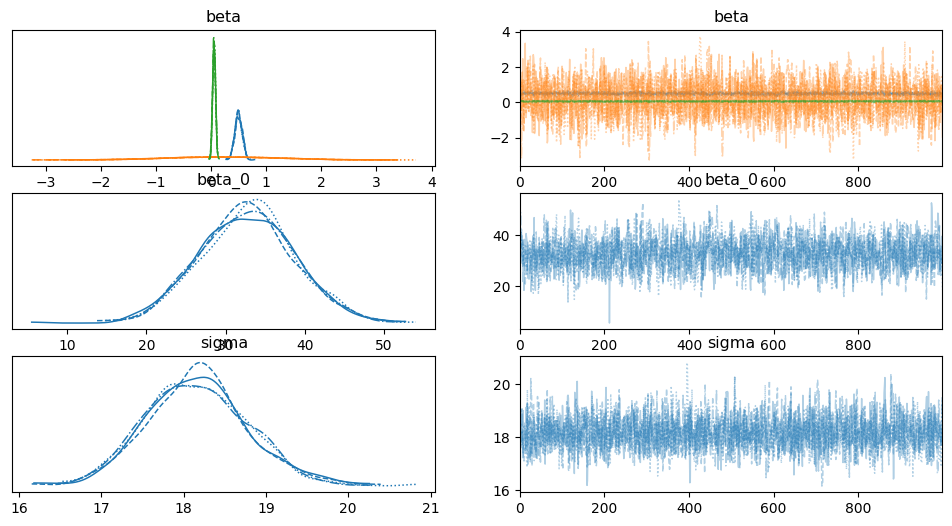

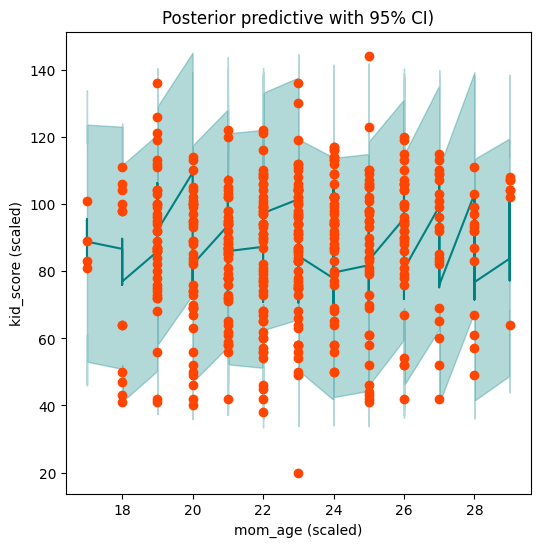

In [ ]:
#@title Model_4
## add additional column in the dataframe as result of the product "mom_iq*mom_hs" columns
df['mom_iq_product_mom_hs']=df['mom_iq']*df['mom_hs']
#### Features/covariate
X=df[['mom_iq','mom_hs','mom_iq_product_mom_hs']].values

##################### Define the regression model ###############
def model4 (X=None, kid_score=None):

    # the number of features
    num_features =X.shape[1]

    # nummber of data points
    num_data = X.shape[0]

    # Priors
    beta_0= numpyro.sample('beta_0', dist.Normal(80, 25))
    beta= numpyro.sample('beta', dist.Normal(jnp.zeros(num_features), jnp.ones(num_features)))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))
    # precompute logits, i.e. the linear predictor
    mean= beta_0 + jnp.dot(X,beta)
    # likelihood. ( handling plate).
    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Normal(mean,sigma), obs=kid_score)

################# Inference ###############################

# Define the number of MCMC samples and the number of warmup steps
num_samples = 1000
num_warmup = 500

# Run NUTS sampler
nuts_kernel = NUTS(model4)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=4, progress_bar=True)
mcmc.run(rng_key, X=X, kid_score=kid_score)


################## Check Convergence ##########################

print('')
# Get posterior samples
samples = mcmc.get_samples()

# Print posterior statistics
mcmc.print_summary()

print('')
# plot posterior distribution and traceplots
data_4= az.from_numpyro(mcmc)
az.plot_trace(data_4, compact=True)

##########################  Posterior predictive  #######################

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model4, samples)
posterior_predictions = predictive(rng_key_, X=X)
post_obs = posterior_predictions['obs']

mean_post_pred = jnp.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.95)

ax = plot_regression(df.mom_age.values, mean_post_pred, hpdi_post_pred,kid_score, ttl="Posterior predictive with 95% CI)")
ax.set(xlabel='mom_age (scaled)', ylabel='kid_score (scaled)')


In [ ]:
#@title compare the 4 models and ouput the summary table
############  WAIC of the models #####################

## model 1
print(' WAIC model 1:')
print('')
print(az.waic(data_1))

## model 2
print('')
print(' WAIC model 2:')
print('')
print(az.waic(data_2))

## model 3
print('')
print(' WAIC model 3:')
print('')
print(az.waic(data_3))


## model 4
print('')
print(' WAIC model 4:')
print('')
print(az.waic(data_4))

print('')

print(' other metrics summary table:')
print('')

az.compare({'model1': data_1, 'model2': data_2, 'model3': data_3, 'model4': data_4})


 WAIC model 1:

Computed from 1000 posterior samples and 434 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1878.79    14.58
p_waic        2.98        -

 WAIC model 2:



<ipython-input-27-1863cdcfc3da>:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  print(az.waic(data_1))
<ipython-input-27-1863cdcfc3da>:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  print(az.waic(data_2))


Computed from 4000 posterior samples and 434 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1877.72    14.51
p_waic        3.04        -

 WAIC model 3:

Computed from 4000 posterior samples and 434 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1877.13    14.31
p_waic        3.89        -

 WAIC model 4:



<ipython-input-27-1863cdcfc3da>:19: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  print(az.waic(data_3))
<ipython-input-27-1863cdcfc3da>:26: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  print(az.waic(data_4))


Computed from 4000 posterior samples and 434 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1877.17    14.30
p_waic        3.96        -

 other metrics summary table:



,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model3,0,-1877.134049,3.901688,0.000000,6.426724e-01,14.308620,0.000000,False,log
model4,1,-1877.176635,3.963694,0.042585,1.038737e-15,14.303704,0.067779,False,log
model2,2,-1877.728765,3.046988,0.594716,3.573276e-01,14.507656,2.069078,False,log
model1,3,-1878.806222,2.992543,1.672173,1.332268e-15,14.581055,2.530717,False,log


# Logistic and other regressions


# TasK 21:
Notice that we are importing one new item from **numpyro.infer** this time: **init_to_median**. Research what it is doing. What are the available alternatives?

##Answer:

"*init_to_median*" is a method from numpyro.infer used for initializing the parameters of a model to the median of their prior distributions; the purpose of using it is to start the inference procedure from a point in the parameter space that is likely to be close to the posterior.

the avalaible alternatives in numpyro are:   **init_to_value()**  , **init_to_uniform()** .

#Hierarchical modelling

# Task 22 :

- Draw a diagram showing the hierarchy in the data. What are the “groups” here?

Complete pooling:
- Suppose that we took a complete pooling approach to modelling `Reaction` time ($y$) by `Days` of sleep deprivation ($x$). Draw a diagram of complete pooling.
- Ignore the subjects and fit the complete pooling model. Visualise the result.

No pooling:
- Construct and discuss separate scatterplots of Reaction by Days for each Subject.
- Fit the no pooling model to the data.


Partial pooling:
- Plot only data for subjects `308` and `335`.
- For these two subjects, provide a loose sketch of three separate trend lines corresponding to a complete pooled, no pooled, and partial pooled model
- Fit a partially poolled model and visualise the results.

In [ ]:
# Get data
df = pd.read_csv('sleepstudy.csv')
# Drop the column
df = df.drop('Unnamed: 0', axis=1)
df.head()

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308


Text(0.5, 1.0, ' visualization')

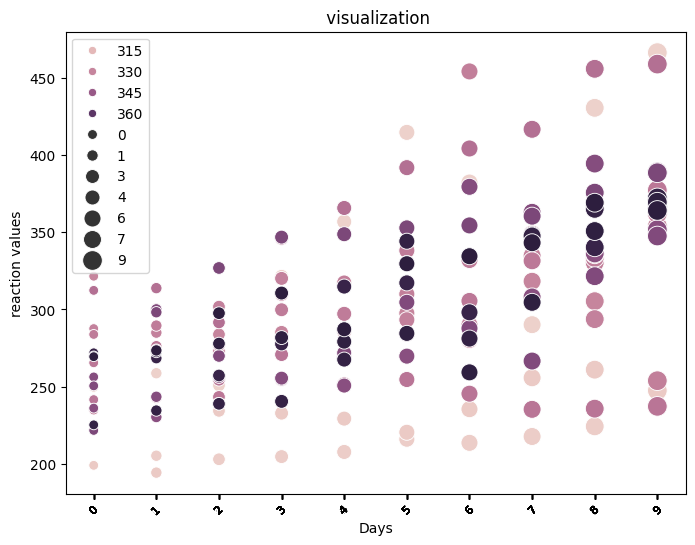

In [ ]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df.Days.values, y=df.Reaction.values, size= df.Days.values,hue=df.Subject.values,sizes=(50, 200))

plt.xticks(df.Days.values,fontsize=8, rotation=45)
# Adding labels and title
plt.xlabel('Days')
plt.ylabel('reaction values')
plt.title(' visualization')

<ipython-input-57-0ebc351acdde>:13: UserWarning: There are not enough devices to run parallel chains: expected 5 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(5)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500,num_chains=5, progress_bar=True)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 1680.00it/s, 5 steps of size 4.56e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0    257.12      5.64    257.14    247.68    266.22   2159.07      1.00
        b1      9.19      1.03      9.18      7.41     10.80   2216.08      1.00
     sigma     43.13      1.97     43.02     40.01     46.42   2302.40      1.00

Number of divergences: 0



[Text(0.5, 0, 'Days (scaled)'), Text(0, 0.5, 'Reaction (scaled)')]

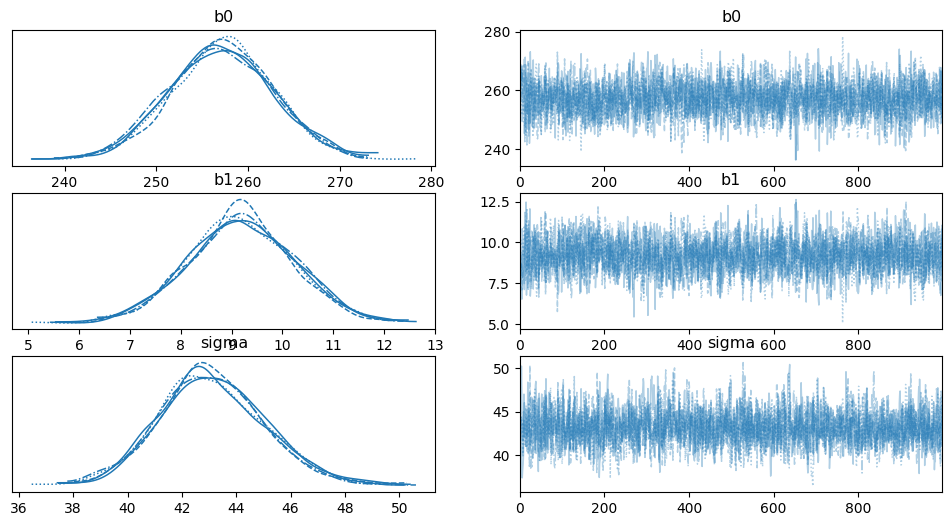

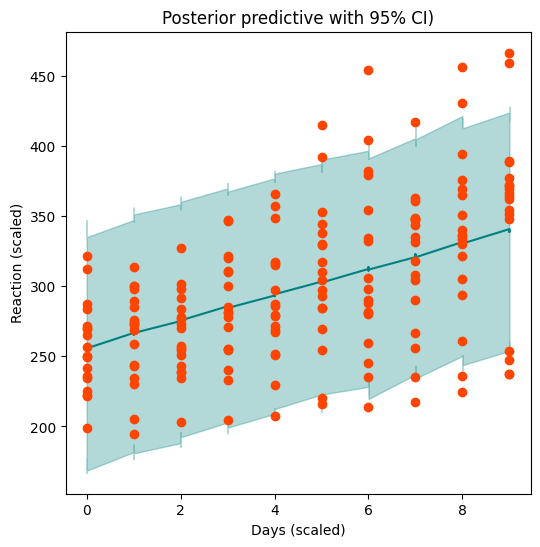

In [ ]:
#@title Complete pooling model
def complete_pooling_model(X=None,y=None):
  num_data=X.shape[0]
  b0 = numpyro.sample(f"b0", dist.Normal(250, 50))
  b1= numpyro.sample(f"b1", dist.Normal(0, 3))
  sigma = numpyro.sample(f"sigma", dist.Exponential(1))
  mu=b0 + b1*X
  with numpyro.plate('data', num_data):
      numpyro.sample(f"obs", dist.Normal(mu, sigma), obs=y)

# Inference
nuts_kernel = NUTS(complete_pooling_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500,num_chains=5, progress_bar=True)
mcmc.run(rng,X=df.Days.values,y=df.Reaction.values)

# Note how many mu-s  and sigma-s are estimated
# we expect 1 mu's estimate ( 2 parameters) and 1 sigma's estimates.
mcmc.print_summary()

print('')
# check convergence ( )
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True)

##########################  Posterior predictive  #######################
samples = mcmc.get_samples()

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(complete_pooling_model, samples)
posterior_predictions = predictive(rng_key_, X=df.Days.values)
post_obs = posterior_predictions['obs']

mean_post_pred = jnp.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.95)

ax = plot_regression(df.Days.values, mean_post_pred, hpdi_post_pred,df.Reaction.values, ttl="Posterior predictive with 95% CI)")
ax.set(xlabel='Days (scaled)', ylabel='Reaction (scaled)')



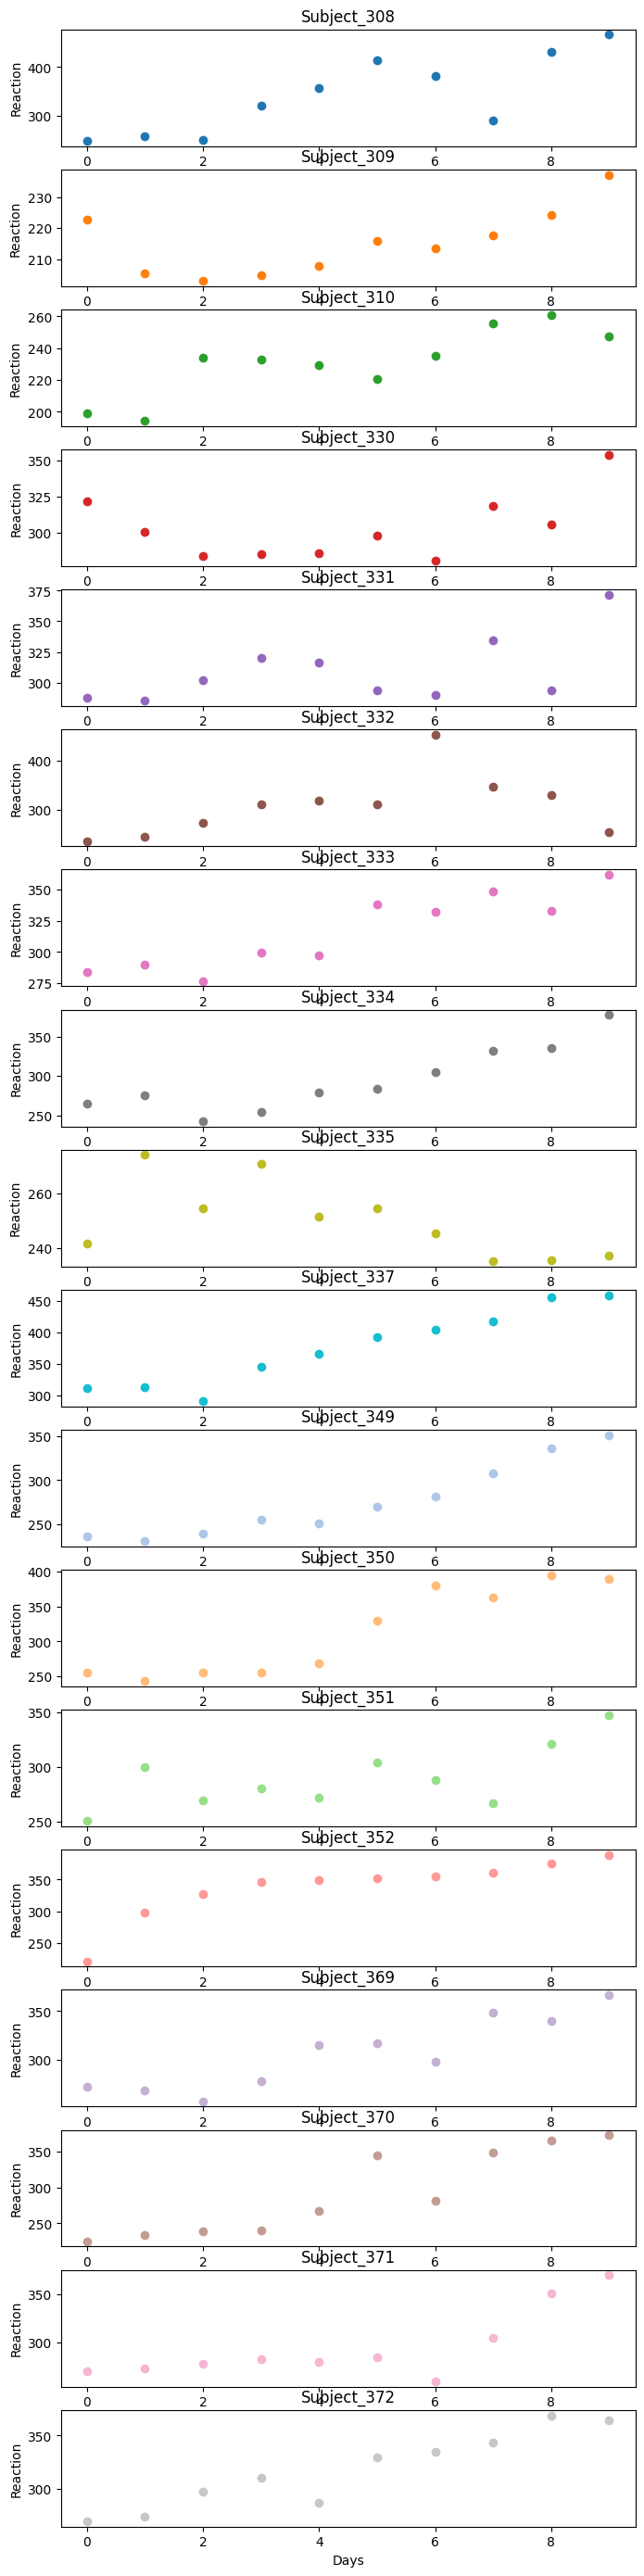

In [ ]:
#@title No pooling

## prepare the data
reaction=df.Reaction.values
# target ( Reaction)
y=reaction.reshape(-1,10)
days=df.Days.values
# covariate ( Days )
X=days.reshape(-1,10)
#
subject=df.Subject.unique()

# pairplot for each subject.

colors =['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7']
fig,ax =plt.subplots(18,figsize=(8,35))
for i in range(X.shape[0]):
  ax[i].scatter(X[i],y[i],color=colors[i])
  ax[i].set_title(f"Subject_{subject[i]}")
  ax[i].set_xlabel('Days')
  ax[i].set_ylabel('Reaction')


## Discussion:
Some scatter plot have the same trend as others but there's no a general trend for all the scatter Plot; meaning that for certains subject, the Reaction evolve differently w.r.t Days. therefore it make sense to fit a model fit the model while assuming that the parameters for model's subjects does no share information each other.

In [ ]:

def no_pooling_model(X,y):
    for i in range(len(y)):
        data=y[i]
        b0 = numpyro.sample(f"$b0_{i}", dist.Normal(0, 10))
        b1= numpyro.sample(f"b1_{i}", dist.Normal(0, 10))
        sigma = numpyro.sample(f"sigma_{i}", dist.Exponential(1))
        mu=b0 + b1*X[i]
        with numpyro.plate('data', len(data)):
          numpyro.sample(f"obs_{i}", dist.Normal(mu, sigma), obs=data)

# Inference
nuts_kernel = NUTS(no_pooling_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500,num_chains=5, progress_bar=True)
mcmc.run(rng,X=X,y=y)

# Note how many mu-s  and sigma-s are estimated
# we expect 18 mu's estimate ( 36 parameters) and 18 sigma's estimates.
mcmc.print_summary()

print('')
# check convergence ( )
# data = az.from_numpyro(mcmc)
# az.plot_trace(data, compact=True)



<ipython-input-46-81df758e5874>:14: UserWarning: There are not enough devices to run parallel chains: expected 5 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(5)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500,num_chains=5, progress_bar=True)
sample: 100%|██████████| 1500/1500 [00:03<00:00, 384.36it/s, 7 steps of size 3.77e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     $b0_0     31.78     10.26     31.76     14.13     47.75   6619.29      1.00
     $b0_1     32.98     10.39     32.82     16.07     49.93   6047.93      1.00
    $b0_10     34.03     10.44     34.00     17.16     51.09   6539.26      1.00
    $b0_11     33.69     10.19     33.74     15.81     49.44   6013.69      1.00
    $b0_12     31.13     10.28     31.23     14.67     48.26   6865.36      1.00
    $b0_13     31.62      9.97     31.72     14.68     47.33   6634.86      1.00
    $b0_14     32.10     10.37     32.07     14.91     48.47   6391.35      1.00
    $b0_15     33.80     10.36     33.82     16.24     50.26   6430.04      1.00
    $b0_16     31.55     10.19     31.64     15.25     48.72   6610.34      1.00
    $b0_17     31.84     10.13     31.98     15.38     48.23   6891.00      1.00
     $b0_2     33.51     10.16     33.44     15.54     48.83   6055.40      1.00
     $b0_3     30.28     10

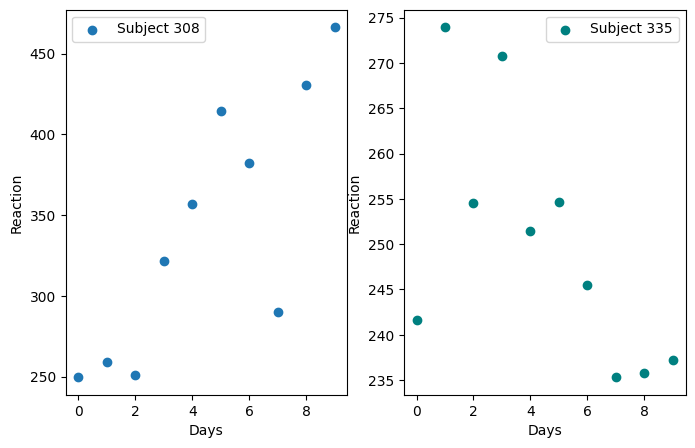

In [ ]:
#@title Partial pooling
subject_308=df[df['Subject']==308]
subject_308
subject_335=df[df['Subject']==335]
subject_335

fig,ax=plt.subplots(1,2,figsize=(8,5))
ax[1].scatter(subject_335['Days'],subject_335['Reaction'],label='Subject 335',color='teal')
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Reaction')
ax[1].legend()
ax[0].scatter(subject_308['Days'],subject_308['Reaction'],label='Subject 308')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Reaction')
ax[0].legend()

In [ ]:
#  prepare data
df2=pd.concat([subject_308,subject_335])
reaction=df2.Reaction.values
# target ( Reaction)
y1=reaction.reshape(-1,10)
days=df2.Days.values
# covariate ( Days )
X1=days.reshape(-1,10)

<ipython-input-77-cb2a4969dfdd>:21: UserWarning: There are not enough devices to run parallel chains: expected 5 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(5)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500,num_chains=5, progress_bar=False)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
alpha_0[0]    259.20    113.51    257.75     79.58    450.30   1247.27      1.00
alpha_0[1]    159.32    171.08    155.41   -108.11    443.51    758.89      1.02
alpha_0[2]    148.25    193.87    146.00   -206.34    430.46    334.66      1.02
alpha_0[3]    217.71    194.71    218.53    -71.59    552.79    352.15      1.01
alpha_0[4]    204.67    206.29    195.40    -62.87    605.80    131.69      1.04
alpha_0[5]    189.95    204.53    194.49   -163.73    489.67     82.64      1.06
alpha_0[6]    212.38    192.83    209.72   -110.93    522.43   2405.94      1.00
alpha_0[7]    207.82    197.70    201.07   -108.81    527.43    282.99      1.02
alpha_0[8]    262.34    254.24    245.58   -197.41    638.47     29.10      1.16
alpha_0[9]    273.49    287.58    237.79   -203.84    619.97     20.48      1.23
alpha_1[0]    243.41    106.29    243.67     78.33    429.57   1178.08      1.01
alpha_1[1]    157.43    170

array([[<Axes: title={'center': 'alpha_0'}>,
        <Axes: title={'center': 'alpha_0'}>],
       [<Axes: title={'center': 'alpha_1'}>,
        <Axes: title={'center': 'alpha_1'}>],
       [<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma_0'}>,
        <Axes: title={'center': 'sigma_0'}>],
       [<Axes: title={'center': 'sigma_1'}>,
        <Axes: title={'center': 'sigma_1'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

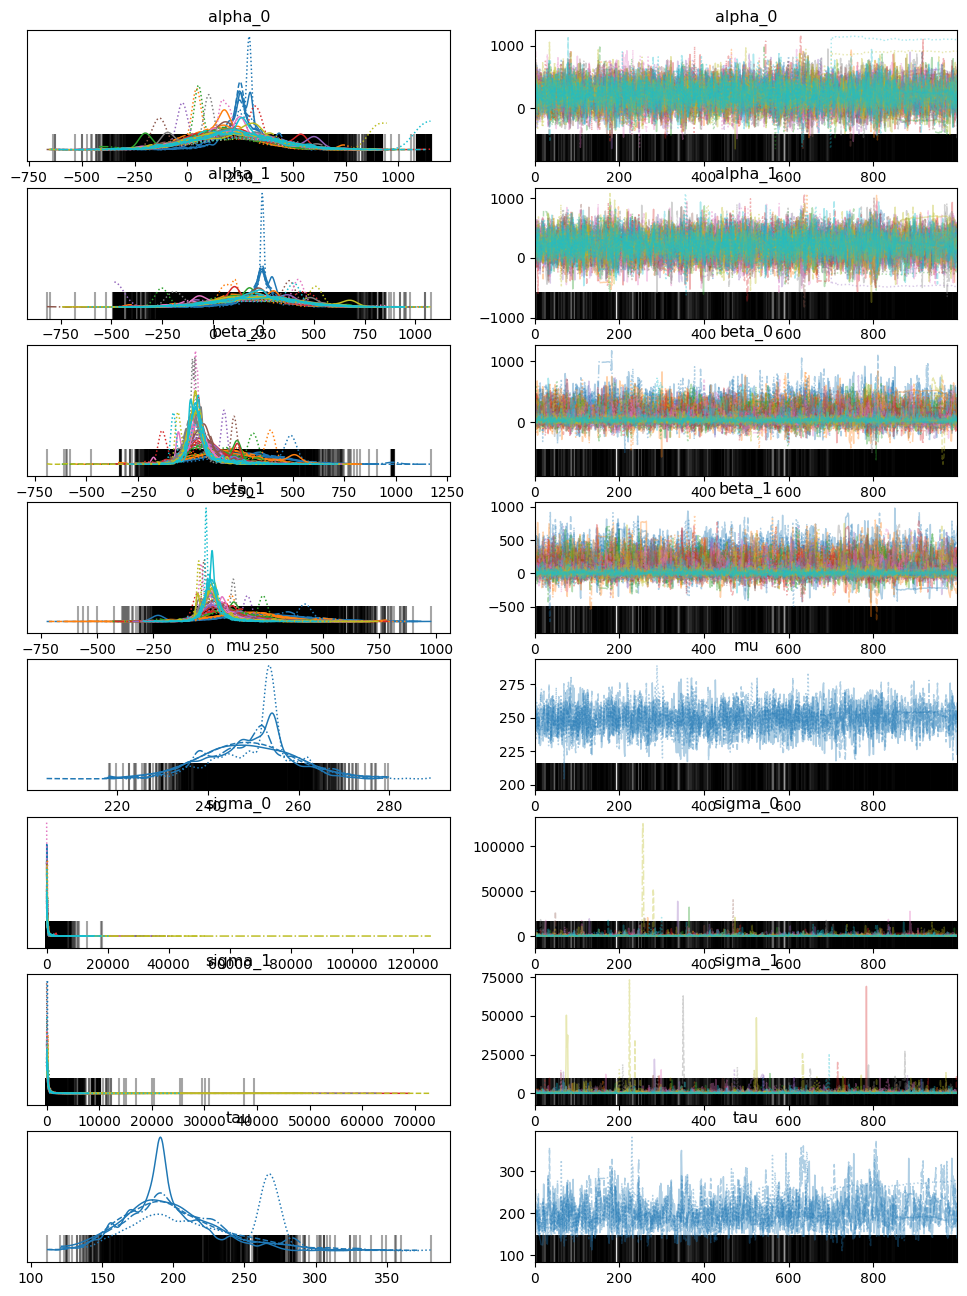

In [ ]:
def partial_pooling_model(X,y):
    # hyperpriors
    mu = numpyro.sample('mu', dist.Normal(260, 10))
    tau = numpyro.sample('tau', dist.HalfCauchy(scale=5))

    for i in range(len(y)):
      data=y[i]
    # prior
      alpha=numpyro.sample(f"alpha_{i}", dist.Normal(mu, tau), sample_shape=(len(data),))
      beta=numpyro.sample(f"beta_{i}", dist.Normal(mu, tau), sample_shape=(len(data),))
      sigma= numpyro.sample(f"sigma_{i}", dist.HalfCauchy(scale=tau ),sample_shape=(len(data),))

      mean= alpha + beta*X[i]
    # Likelihood
      with numpyro.plate('data', len(data)):
        numpyro.sample(f"obs_{i}", dist.Normal(mean, sigma), obs=data)


# Inference
nuts_kernel = NUTS(partial_pooling_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500,num_chains=5, progress_bar=True)
mcmc.run(jax.random.PRNGKey(0), y=y1, X=X1)

# Get posterior samples
posterior_samples = mcmc.get_samples()

# Print summary statistics
mcmc.print_summary()

print('')
# check convergence ( )
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True)



## Task 23

sleep.csv data set

In [6]:
# Get datas
sleep_df= pd.read_csv('sleep.csv')
# Drop the column
sleep_df

,extra,group,ID
0,0.7,1,1
1,-1.6,1,2
2,-0.2,1,3
3,-1.2,1,4
4,-0.1,1,5
5,3.4,1,6
6,3.7,1,7
7,0.8,1,8
8,0.0,1,9
9,2.0,1,10


Text(0.5, 1.0, ' visualization')

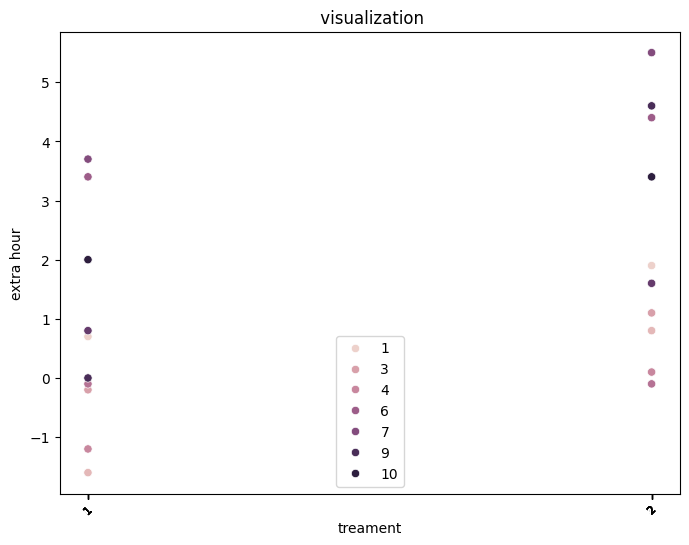

In [10]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.scatterplot(x=sleep_df.group.values, y=sleep_df.extra.values,hue=sleep_df.ID.values,sizes=(50, 200))

plt.xticks(sleep_df.group.values,fontsize=8, rotation=45)
# Adding labels and title
plt.xlabel('treament')
plt.ylabel('extra hour')
plt.title(' visualization')

I think that drug 2 have an effect.